In [1]:
import ntpath
import os

import matplotlib.pyplot as plt
import numpy as np
from imutils import paths
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
# 初始化訓練用參數與Batch Size
INIT_LR = 1e-4
EPOCHS = 50
batch_size = 32

## 載入圖片，並將訓練圖片進行前處理與建立訓練data

In [3]:
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.mobilenet_v2 import preprocess_input

# 載入圖片
print("[INFO] loading images...")
imagePaths = list(paths.list_images(r'../../dataset'))
data = []
labels = []

# 將訓練圖片進行前處理與建立訓練data
for imagePath in imagePaths:
    label = ntpath.normpath(imagePath).split(os.path.sep)[-2]

    # 注意這裡將圖片轉成224 x 224，與MobileNetV2模型需要的Input一樣大小
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    data.append(image)
    labels.append(label)

data = np.array(data, dtype="float32")
labels = np.array(labels)

print(f'Got Image dataset. Shapes: \n{data.shape}')
examples = labels[np.random.choice(len(labels), 5)]
print(f'Random choice Labels: \n{examples}')

[INFO] loading images...
Got Image dataset. Shapes: 
(1376, 224, 224, 3)
Random choice Labels: 
['with_mask' 'with_mask' 'without_mask' 'with_mask' 'with_mask']


## 將類別 encoding 成數值以方便訓練

In [4]:
from keras.utils.np_utils import to_categorical

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [5]:
examples = labels[np.random.choice(len(labels), 5)]
print(f'Random choice Labels: \n{examples}')

Random choice Labels: 
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


## 切分訓練資料與測試資料

In [6]:

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=9527)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1100, 224, 224, 3) (1100, 2) (276, 224, 224, 3) (276, 2)


## Data Augmentation

In [7]:
from keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")

In [8]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import *
from keras.models import Model
from keras.optimizer_v2.adam import Adam
from keras.losses import binary_crossentropy

def build_model():
    # 載入模型，去除模型最後一層 (等等要改為我們要辨識的"兩種類別")
    baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

    # 組合自定義的最後層
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)

    # 建立模型
    model = Model(inputs=baseModel.input, outputs=headModel)

    # 確認模型只有我們新增的最後層可以訓練 (transfer learning)
    for layer in baseModel.layers:
        layer.trainable = False

    # 編譯模型
    print("[INFO] compiling model...")
    opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss=binary_crossentropy, optimizer=opt, metrics=["accuracy"])
    return model

In [9]:
model = build_model()
model.summary()

[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                   

C:\Users\boshi\anaconda3\envs\boshi_intretech\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


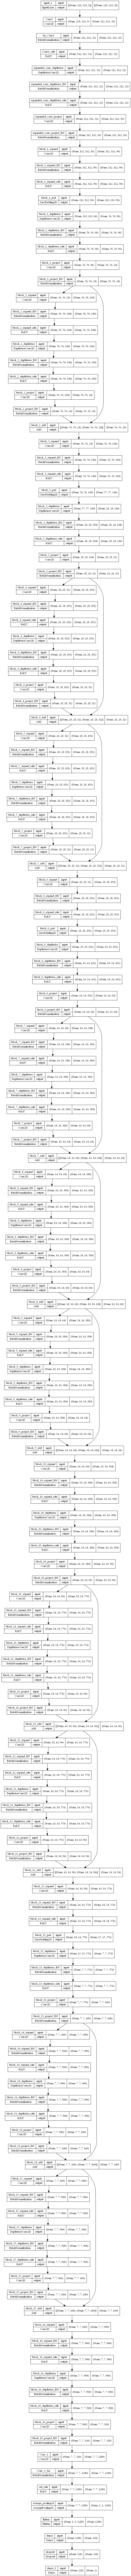

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# 開始訓練
print("[INFO] training head...")
from keras.callbacks import *
lr = ReduceLROnPlateau(monitor="val_accuracy", mode='max', factor=0.7, patience=4, verbose=False)
es = EarlyStopping(monitor='val_accuracy',mode='max', patience=10, verbose=False,restore_best_weights=True)

history = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    validation_data=(testX, testY),
    epochs=EPOCHS,
    callbacks=[lr, es],
)

[INFO] training head...
Epoch 1/50
35/35 [==============================] - 9s 254ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.0129 - val_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 2/50
35/35 [==============================] - 9s 255ms/step - loss: 0.0123 - accuracy: 0.9991 - val_loss: 0.0115 - val_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 3/50
35/35 [==============================] - 9s 256ms/step - loss: 0.0128 - accuracy: 0.9973 - val_loss: 0.0138 - val_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 4/50
35/35 [==============================] - 9s 255ms/step - loss: 0.0103 - accuracy: 0.9991 - val_loss: 0.0139 - val_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 5/50
35/35 [==============================] - 9s 256ms/step - loss: 0.0111 - accuracy: 0.9982 - val_loss: 0.0098 - val_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 6/50
35/35 [==============================] - 9s 253ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.0116 - val_accuracy: 0.9964 - lr: 7.0000e-05
Epoch 7/50
35/35 [====

## 使用測試資料驗證模型準確率

In [13]:

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)

# 印出測試結果
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      1.00       138
without_mask       0.99      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [18]:
predIdxs

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1], dtype=int64)

In [14]:
# 儲存模型
print("[INFO] saving mask detector model...")
model.save('../../saved_model/model', save_format="h5")
print("[INFO] model saved.")

[INFO] saving mask detector model...
[INFO] model saved.


In [15]:
# 劃出訓練結果
def plot_history(history):
    N = EPOCHS
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig('model_performance.png')

ValueError: x and y must have same first dimension, but have shapes (50,) and (11,)

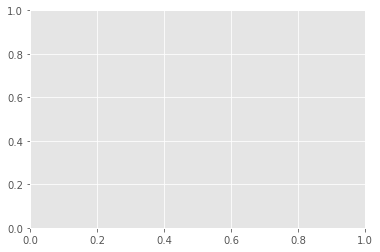

In [17]:
plot_history(history=history.history)